In [1]:
!pip install d2l


     |████████████████████████████████| 83 kB 1.2 MB/s 


In [2]:
import os
import torch
from d2l import torch as d2l

In [3]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [4]:
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [5]:
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

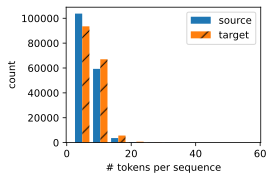

In [6]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs."""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target);

In [7]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [8]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [9]:
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [10]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [11]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tensor([[ 66,  15,   4,   3,   1,   1,   1,   1],
        [162,   9,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
valid lengths for X: tensor([4, 4])
Y: tensor([[ 78,   5,   3,   1,   1,   1,   1,   1],
        [171,   5,   3,   1,   1,   1,   1,   1]], dtype=torch.int32)
valid lengths for Y: tensor([3, 3])


# Transformer


In [13]:
import torch.nn as nn
import math

In [14]:
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [15]:
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [16]:
class EncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [17]:
class TransformerEncoder(d2l.Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [18]:
class DecoderBlock(nn.Module):
    # The `i`-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of `enc_outputs`:
        # (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [19]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.033, 5282.4 tokens/sec on cuda:0


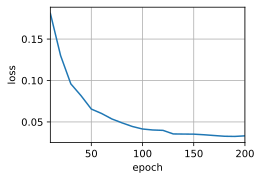

In [20]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [21]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est bon .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000
